# Simple Interpretability for LLMs

first, we want to choose a model. You can use this table: https://miv.name/transformerlens-model-table/. for this tutorial, we use `tiny-stories-3M`

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import torch
from transformer_lens import HookedTransformer
from jaxtyping import Float, Int
from muutils.dictmagic import condense_tensor_dict

In [2]:
# load a subset of the tinystories dataset
with open("../data/tinystories_10k.txt", "r", encoding="utf-8") as f:
	TEXT_DATA: list[str] = f.read().split("<|endoftext|>")

In [3]:
# MODEL: HookedTransformer = HookedTransformer.from_pretrained("tiny-stories-3M")
MODEL: HookedTransformer = HookedTransformer.from_pretrained("gpt2")

Loaded pretrained model gpt2 into HookedTransformer


In [4]:
d_model: int = MODEL.cfg.d_model
n_layers: int = MODEL.cfg.n_layers
n_heads: int = MODEL.cfg.n_heads
d_vocab: int = MODEL.cfg.d_vocab

print(f"{d_model=}, {n_layers=}, {n_heads=}, {d_vocab=}")

d_model=768, n_layers=12, n_heads=12, d_vocab=50257


# Understanding embeddings

The model has Token embeddings $W_E \in \R^{d_v \times d_m}$ and positional embeddings $W_P \in \R^{n_c \times d_m}$. We want to understand:

- what portions of the residual stream do they write to?
	- are these regions disjoint?
- what do these embeddings do?
	- for the learned positional embeddings, we can try an FFT
	- token embeddings are trickier, but we can try PCA and some clustering

torch.Size([512, 768])


(-2.0, 2.0)

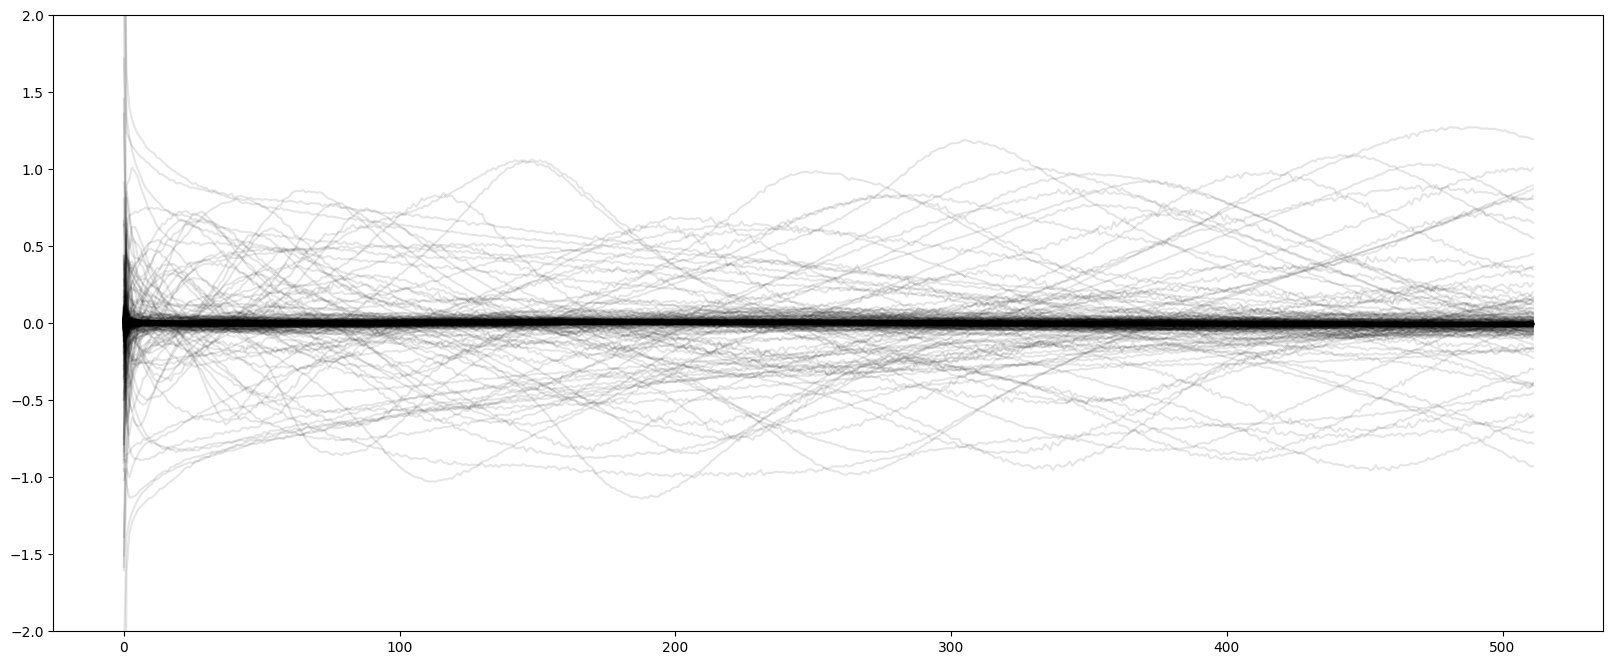

In [60]:
W_pos: Float[torch.Tensor, "n_context d_model"] = MODEL.W_pos.cpu().detach()
W_pos = W_pos[:512]
print(W_pos.shape)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
for i in range(W_pos.shape[1]):
	ax.plot(W_pos[:,i], color="black", alpha=0.1)
ax.set_ylim(-2, 2)

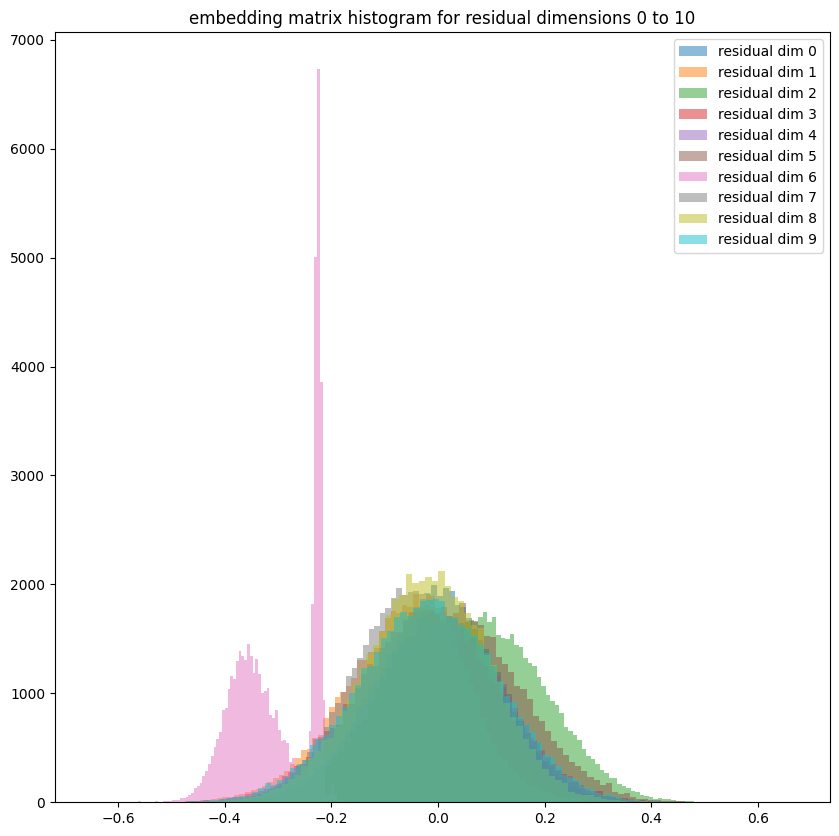

In [6]:
def plot_dim_embedding_hist(model: HookedTransformer, r_0, r_1=None):

    if r_1 is None:
        r_1 = r_0
        r_0 = 0

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # for i in range(MODEL.cfg.d_model):
    for i in range(r_0, r_1):
        ax.hist(
            model.W_E.T[i].detach().cpu().numpy(),
            bins=100,
            alpha=0.5,
            label=f"residual dim {i}",
        )
    ax.legend()
    ax.set_title(f"embedding matrix histogram for residual dimensions {r_0} to {r_1}")
    plt.show()

plot_dim_embedding_hist(MODEL, 10)

# Logit Lens

The unembedding map $W_U \in \R^{d_m \times d_v}$ can be, in principle, used to map any vector from the residual stream to the output vocabulary. This technique is know as *Logit Lens*.

https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens

In [7]:
prompt: str = "Once upon a time, there was a hunter. He lived in a small house near the woods. He had a dog named Spot."


In [8]:

MODEL.generate(prompt, max_new_tokens=20)


  0%|          | 0/20 [00:00<?, ?it/s]

'Once upon a time, there was a hunter. He lived in a small house near the woods. He had a dog named Spot.\n\nIt was Capra who got his claws up.\n\nTom went to the house periodically'

In [53]:
prompt_encoded = MODEL.tokenizer.encode(prompt)
prompt_tokenized = MODEL.tokenizer.tokenize(prompt)
# replace funky G character with a space, in each of the tokenized ones
prompt_tokenized = [tok.replace("Ġ", " ") for tok in prompt_tokenized]
print(prompt_encoded)
# a quick sanity check
print(prompt_tokenized)
print(MODEL.tokenizer.decode(prompt_encoded))

[7454, 2402, 257, 640, 11, 612, 373, 257, 19177, 13, 679, 5615, 287, 257, 1402, 2156, 1474, 262, 16479, 13, 679, 550, 257, 3290, 3706, 15899, 13]
['Once', ' upon', ' a', ' time', ',', ' there', ' was', ' a', ' hunter', '.', ' He', ' lived', ' in', ' a', ' small', ' house', ' near', ' the', ' woods', '.', ' He', ' had', ' a', ' dog', ' named', ' Spot', '.']
Once upon a time, there was a hunter. He lived in a small house near the woods. He had a dog named Spot.


In [9]:
logits, cache = MODEL.run_with_cache(prompt)

In [10]:
print(condense_tensor_dict(cache, return_format="yaml"))

blocks:
  '[0-11]':
    ln1:
      hook_scale: (1, 28, 1)
      hook_normalized: (1, 28, 768)
    attn:
      '[hook_q, hook_k, hook_v, hook_z]': (1, 28, 12, 64)
      '[hook_attn_scores, hook_pattern]': (1, 12, 28, 28)
    ln2:
      hook_scale: (1, 28, 1)
      hook_normalized: (1, 28, 768)
    mlp:
      '[hook_pre, hook_post]': (1, 28, 3072)
    '[hook_resid_pre, hook_attn_out, hook_resid_mid, hook_mlp_out, hook_resid_post]': (1,
      28, 768)
ln_final:
  hook_scale: (1, 28, 1)
  hook_normalized: (1, 28, 768)
'[hook_embed, hook_pos_embed]': (1, 28, 768)



In [45]:
def decode_residual_vector(x: Float[torch.Tensor, "d_model"], top_n: int = 1) -> tuple[str, float]|list[tuple[str, float]]:
	x_logits: Float[torch.Tensor, "d_vocab"] = x @ MODEL.W_U
	x_logits_softmax: Float[torch.Tensor, "d_vocab"] = torch.softmax(x_logits, dim=0)
	topk: Int[torch.Tensor, "top_n"] = torch.topk(x_logits_softmax, top_n)
	top_probs: Float[torch.Tensor, "top_n"] = topk.values.detach().cpu()
	top_indices: Int[torch.Tensor, "top_n"] = topk.indices.detach().cpu()
	top_words: list[str] = [MODEL.tokenizer.decode(i) for i in top_indices]
	if top_n == 1:
		return top_words[0], top_probs[0].item()
	else:
		return list(zip(top_words, top_probs.tolist()))

In [54]:
for i in range(len(prompt_encoded)):
	cache_element = cache['blocks.11.hook_resid_post'][0][i]
	decoded = decode_residual_vector(cache_element, top_n=1)
	print(f"{prompt_tokenized[i]:<15}{decoded[0]:<15}{decoded[1]:.3f}")

Once           Story          0.977
 upon           upon          0.749
 a              a             1.000
 time           time          1.000
,               there         0.827
 there          astronomers   0.999
 was            existed       0.847
 a              nothing       0.964
 hunter         guy           0.734
.               named         1.000
 He             He            1.000
 lived          hunted        1.000
 in             alone         1.000
 a              caves         0.998
 small          cave          0.998
 house          village       1.000
 near           overlooking   0.997
 the            Lake          1.000
 woods          village       0.880
.               overlooking   1.000
 He             He            1.000
 had            hunted        1.000
 a              hunted        1.000
 dog            rifle         1.000
 named          named         1.000
 Spot           Teddy         0.889
.              ty             0.999


In [57]:
# Initialize an empty list to store the data for each layer
data = []

# Iterate over the layers
for layer in range(12):
    layer_data = []
    
    for i in range(len(prompt_encoded)):
        cache_element = cache[f'blocks.{layer}.hook_resid_post'][0][i]
        decoded = decode_residual_vector(cache_element, top_n=1)
        
        # Append the data for each token to the layer_data list
        layer_data.append([prompt_tokenized[i], decoded[0], decoded[1]])
    
    # Create a DataFrame for the current layer
    layer_df = pd.DataFrame(layer_data, columns=['Actual Token', f'pred L:{layer}', f'score L:{layer}'])
    
    # Append the layer DataFrame to the data list
    data.append(layer_df)

# Concatenate all the layer DataFrames horizontally
result_df = pd.concat(data, axis=1)

# Drop duplicate 'Actual Token' columns
result_df = result_df.loc[:, ~result_df.columns.duplicated()]

# Display the resulting DataFrame
result_df

,Actual Token,pred L:0,score L:0,pred L:1,score L:1,pred L:2,score L:2,pred L:3,score L:3,pred L:4,...,pred L:7,score L:7,pred L:8,score L:8,pred L:9,score L:9,pred L:10,score L:10,pred L:11,score L:11
0,Once,Loading,0.524625,\n,0.999990,\n,1.000000,\n,1.000000,\n,...,\n,1.000000,\n,1.000000,\n,1.000000,\n,1.000000,Story,0.977058
1,upon,more,0.801164,Upon,0.759993,Upon,0.870954,Upon,0.991314,Upon,...,Upon,1.000000,Upon,0.929740,again,1.000000,again,1.000000,upon,0.748530
2,a,arrival,0.733399,arrival,0.952869,arrival,0.998787,arrival,0.993443,arrival,...,awhile,1.000000,awhile,1.000000,awhile,1.000000,a,1.000000,a,1.000000
3,time,steady,0.569276,steady,0.475680,couple,0.417503,couple,0.922494,couple,...,occasion,0.642632,rainy,0.987087,time,1.000000,time,1.000000,time,1.000000
4,",",frames,0.609480,frames,0.469507,frames,0.479520,capsule,0.356914,ago,...,there,0.999978,there,0.999999,there,0.656627,",",0.988084,there,0.826546
5,there,albeit,0.795713,albeit,0.901212,please,0.388116,however,0.989118,however,...,there,0.449229,astronomers,0.998546,astronomers,0.996702,astronomers,0.676543,astronomers,0.999261
6,was,abouts,0.999993,abouts,1.000000,abouts,0.999995,abouts,0.999001,abouts,...,abouts,0.998857,abouts,0.999984,existed,0.991784,existed,0.999917,existed,0.846755
7,a,definitely,0.388560,definitely,0.675075,definitely,0.888395,definitely,0.520182,plenty,...,plenty,0.999993,plenty,0.999992,plenty,0.860794,no,0.551723,nothing,0.963581
8,hunter,few,0.300493,few,0.323619,lot,0.811447,lot,0.989530,lot,...,lot,0.977076,strange,0.754276,rumor,0.874240,guy,0.978398,guy,0.734413
9,.,hunter,1.000000,hunter,1.000000,hunter,1.000000,hunter,1.000000,hunter,...,hunter,1.000000,hunter,1.000000,hunter,1.000000,who,0.528854,named,0.999999


# Tuned Lens

It turns out that the representations of tokens drift throughout the transformer. we can convince ourselves of this by trying to directly decode embeddings of various tokens, and seeing that the representation does not match:

A popular solution to this is *Tuned Lens*: rather than directly taking the unembedding of a residual stream position, we train a linear model to predict later layers from earlier ones.

https://arxiv.org/pdf/2303.08112.pdf

In practice, this is done with KL divergence and we train it to predict the output logits:

$$
\operatorname{argmin} \underset{\boldsymbol{x}}{\mathbb{E}}\left[D_{K L}\left(f_{>\ell}\left(\boldsymbol{h}_{\ell}\right) \| \text { TunedLens }_k\left(\boldsymbol{h}_{\ell}\right)\right)\right]
$$

For simplicity, we will simply have it predict the final pre-unebedding residuals.

# Direct Logit Attribution

If we have a set of (prompt, completion) where completion is a single token, we can figure out which components of the network are most responsible for that correct prediction. Roughly, this is done by taking the dot product of the output of a head (or a neuron) with the embedding (or unembedding, or TunedLens representation) of the correct next token.

We will also need a dataset, which we will generate with the help of GPT-4.